In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# Load data
# ---------------------------
data = pd.read_csv("/content/test_data.csv")

X = data.drop('xAttack', axis=1)
y = data['xAttack']

# Identify categorical/numeric (adjust if there are more categorical features)
categorical_features = ['protocol_type']
numeric_features = X.columns.drop(categorical_features, errors='ignore')

# Encode categorical features
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))
    label_encoders[feature] = le

# Fill missing numeric values
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].mean())

# Scale numeric features
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Encode target
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y.astype(str))

# Full train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---------------------------
# Speedy CSA setup
# ---------------------------
population_size = 12    # keep small for faster iterations
max_generations = 8     # fewer generations for speed
validation_fraction = 0.25  # use a small validation subset for fitness evaluations
rng = np.random.RandomState(42)

# Pre-seed a small validation subset (low-fidelity eval)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=validation_fraction, random_state=42, stratify=y_train_full
)

# Fitness function with conditional model choice and options to be fast
def fitness(params):
    C, kernel, gamma = params

    # If kernel is linear, use LinearSVC which is much faster on linear problems
    if kernel == 'linear':
        model = LinearSVC(C=C, max_iter=5000, tol=1e-3, random_state=42)
    else:
        # Use a bigger cache_size for kernel SVM if you have RAM
        model = SVC(C=C, kernel='rbf', gamma=gamma, cache_size=1000, tol=1e-3, random_state=42)

    # Train on the small train subset and validate on validation subset for speed
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

# Parallel evaluation wrapper
def evaluate_population(pop):
    # Use all available cores; n_jobs=-1
    scores = Parallel(n_jobs=-1)(
        delayed(fitness)(params) for params in pop
    )
    return np.array(scores)

# Initialize population (mix linear and rbf)
population = []
for _ in range(population_size):
    C = 10 ** rng.uniform(-3, 3)
    kernel = 'linear' if rng.rand() > 0.5 else 'rbf'
    if kernel == 'linear':
        gamma = None
    else:
        gamma = 10 ** rng.uniform(-3, 3)
    population.append((C, kernel, gamma))

# CSA-like loop (kept simple and fast)
for generation in range(max_generations):
    fitness_scores = evaluate_population(population)

    # Keep top 20% (at least 1)
    num_selected = max(1, int(population_size * 0.2))
    selected_indices = np.argsort(fitness_scores)[-num_selected:]

    # Keep the selected
    new_population = [population[i] for i in selected_indices]

    # Fill rest randomly (mutation)
    while len(new_population) < population_size:
        C = 10 ** rng.uniform(-3, 3)
        kernel = 'linear' if rng.rand() > 0.5 else 'rbf'
        gamma = None if kernel == 'linear' else 10 ** rng.uniform(-3, 3)
        new_population.append((C, kernel, gamma))

    population = new_population
    print(f"Generation {generation+1}: Best fitness (val subset) = {fitness_scores.max():.4f}")

# After CSA finishes, evaluate final population on full training set (higher-fidelity) to pick best params
def full_train_score(params):
    C, kernel, gamma = params
    if kernel == 'linear':
        model = LinearSVC(C=C, max_iter=10000, tol=1e-4, random_state=42)
    else:
        model = SVC(C=C, kernel='rbf', gamma=gamma, cache_size=1000, tol=1e-4, random_state=42)
    model.fit(X_train_full, y_train_full)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds), model

# Evaluate each candidate (sequential here since population is small) and pick best
best_score = -np.inf
best_params = None
best_model = None
for params in population:
    score, model = full_train_score(params)
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

print("Best params (final):", best_params)
print("Best accuracy on test set (final):", best_score)

# Final evaluation & report
y_pred_svm = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le_y.classes_))
print("Test accuracy:", accuracy_score(y_test, y_pred_svm))

# ---------------------------
# Predict custom datapoint (ensure correct column order and scaling)
# ---------------------------
custom_data_point = pd.DataFrame({
    'duration': [0],
    'protocol_type': [0], # should be in the encoded domain; if you want raw string, re-encode using stored LabelEncoder
    'service': [25],
    'flag': [2],
    'src_bytes': [491],
    'dst_bytes': [420],
    'land':[0],
    'wrong_fragment': [0],
    'urgent': [0],
    'hot': [0],
    'num_failed_logins': [2],
    'logged_in': [1],
    'num_compromised': [2],
    'root_shell': [0],
    'su_attempted': [0],
    'num_root': [0],
    'num_file_creations': [0],
    'num_shells': [0],
    'num_access_files': [0],
    'num_outbound_cmds': [0],
    'is_host_login': [0],
    'is_guest_login': [0],
    'count': [7],
    'srv_count': [31],
    'serror_rate': [0.2],
    'srv_serror_rate': [0.2],
    'rerror_rate': [0],
    'srv_rerror_rate': [0],
    'same_srv_rate': [0.07],
    'diff_srv_rate': [0],
    'srv_diff_host_rate': [0],
    'dst_host_count': [150],
    'dst_host_srv_count':[255],
    'dst_host_same_srv_rate': [0.17],
    'dst_host_diff_srv_rate': [0.05],
    'dst_host_same_src_port_rate': [0.88],
    'dst_host_srv_diff_host_rate': [1],
    'dst_host_serror_rate':[0.07],
    'dst_host_srv_serror_rate':[0.6],
    'dst_host_rerror_rate': [0.05],
    'dst_host_srv_rerror_rate': [0]
}, index=[0])

custom_data_point = custom_data_point[X.columns]  # align columns
custom_data_point[numeric_features] = scaler.transform(custom_data_point[numeric_features])
custom_pred_encoded = best_model.predict(custom_data_point)
custom_pred = le_y.inverse_transform(custom_pred_encoded)
print("Predicted Attack Type for Custom Data Point (SVM):", custom_pred)


Generation 1: Best fitness (val subset) = 0.9750


>>> Quick dataset overview
Shape: (10000, 42)

Columns and dtypes:
duration                         int64
protocol_type                   object
service                          int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,xAttack
0,0,icmp,25,4,0,0,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.65,0.65,0.32,0.32,dos
1,0,icmp,25,2,312,1856,0,0,0,0,...,254,1.00,0.00,1.00,0.06,0.00,0.00,0.00,0.00,normal
2,0,icmp,25,2,245,2058,0,0,0,0,...,255,1.00,0.00,0.01,0.05,0.01,0.00,0.00,0.00,normal
3,0,icmp,25,2,298,1267,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
4,0,icmp,20,2,740,0,0,0,0,0,...,19,0.18,0.03,0.18,0.00,0.00,0.00,0.00,0.00,normal



>>> Missing values (by column):
No missing values detected

>>> Target ('xAttack') value counts:
xAttack
normal    4329
dos       3332
r2l       1199
probe     1053
u2r         87
Name: count, dtype: int64

Target proportions (normalized):
xAttack
normal    0.433
dos       0.333
r2l       0.120
probe     0.105
u2r       0.009
Name: proportion, dtype: float64

Numeric columns count: 40
Categorical columns count: 2

>>> Numeric summary (describe):


,count,mean,std,min,25%,50%,75%,max
duration,10000.0,229.263000,1461.180594,0.0,0.00,0.00,0.0000,57715.0
service,10000.0,35.451700,15.824769,1.0,25.00,25.00,50.0000,70.0
flag,10000.0,2.202900,1.078540,1.0,2.00,2.00,2.0000,11.0
src_bytes,10000.0,6845.031500,86754.085289,0.0,0.00,54.00,285.0000,6291668.0
dst_bytes,10000.0,1996.998700,20069.749604,0.0,0.00,44.00,599.0000,1285078.0
land,10000.0,0.000500,0.022356,0.0,0.00,0.00,0.0000,1.0
wrong_fragment,10000.0,0.009000,0.146701,0.0,0.00,0.00,0.0000,3.0
urgent,10000.0,0.000600,0.031619,0.0,0.00,0.00,0.0000,2.0
hot,10000.0,0.093200,0.647731,0.0,0.00,0.00,0.0000,30.0
num_failed_logins,10000.0,0.021200,0.148838,0.0,0.00,0.00,0.0000,3.0



Top 10 numeric features correlated (abs Spearman) with target:


,0
count,0.537240
srv_count,0.420626
same_srv_rate,0.364609
dst_host_count,0.344661
dst_host_srv_serror_rate,0.334835
dst_host_srv_rerror_rate,0.316085
dst_host_rerror_rate,0.311656
srv_serror_rate,0.306041
rerror_rate,0.305062
dst_host_same_src_port_rate,0.299544


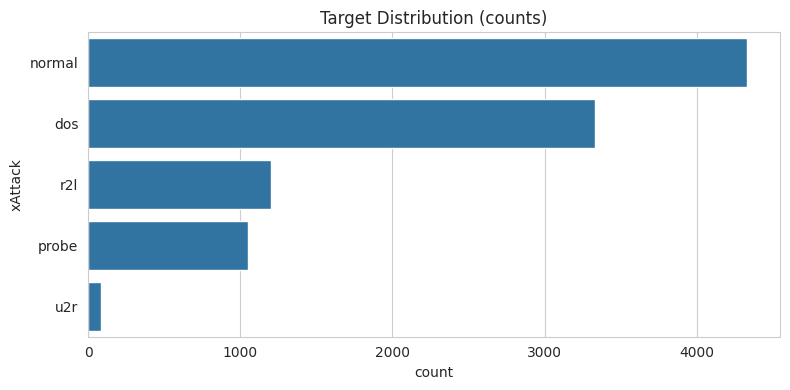

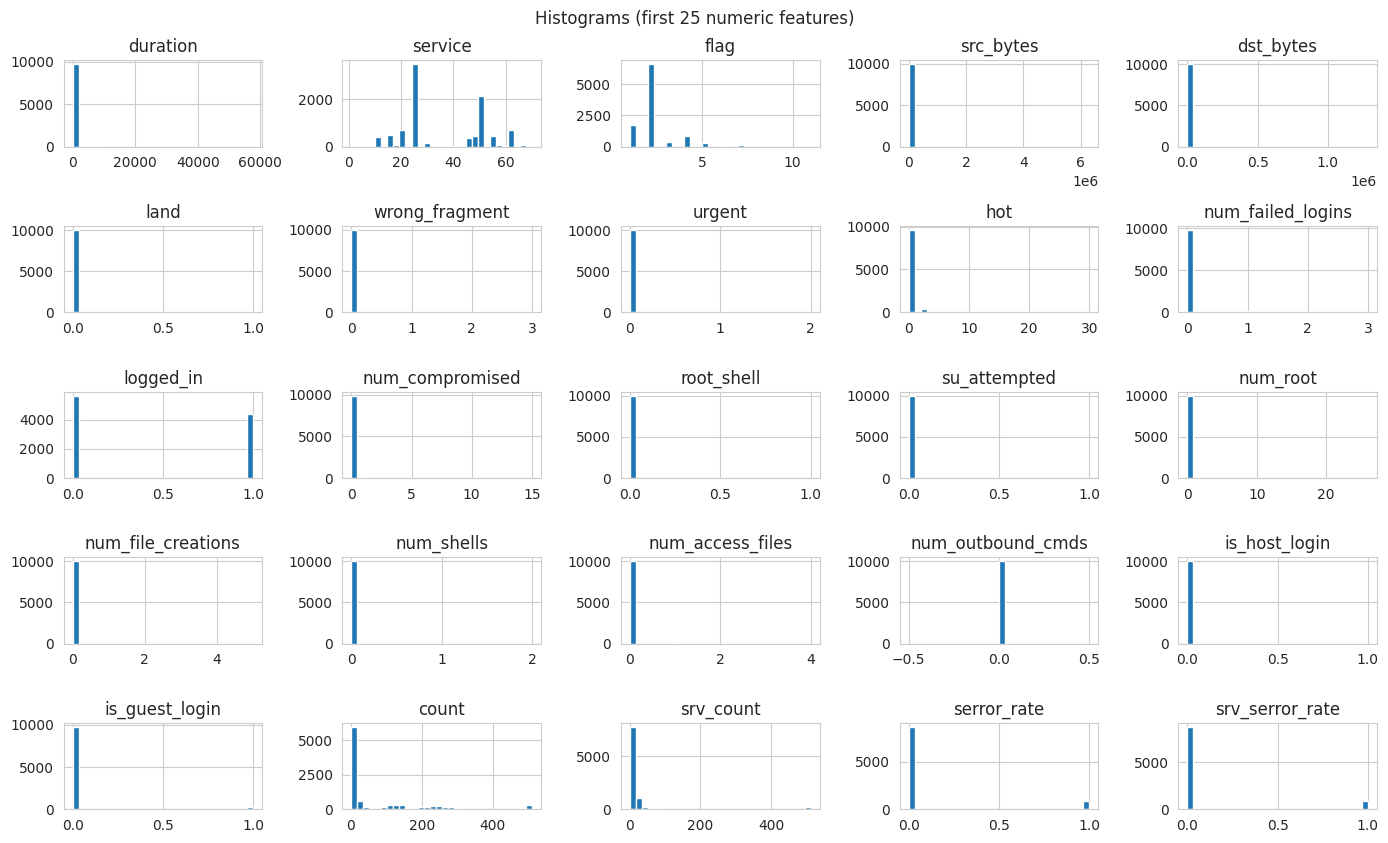

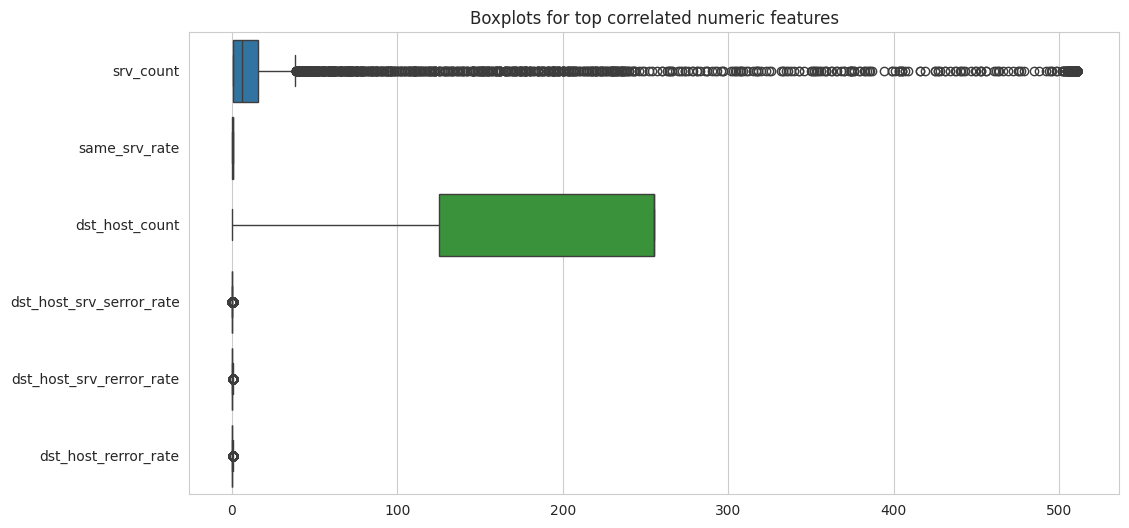

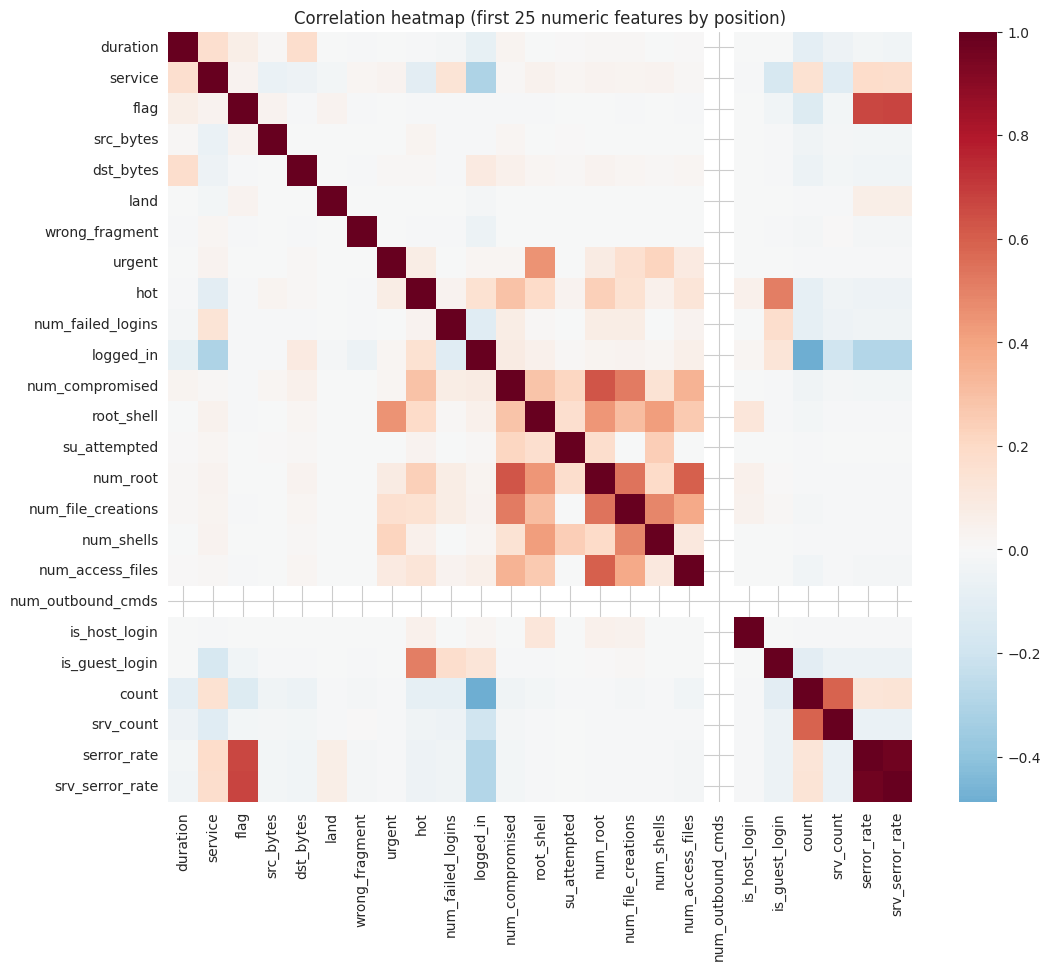

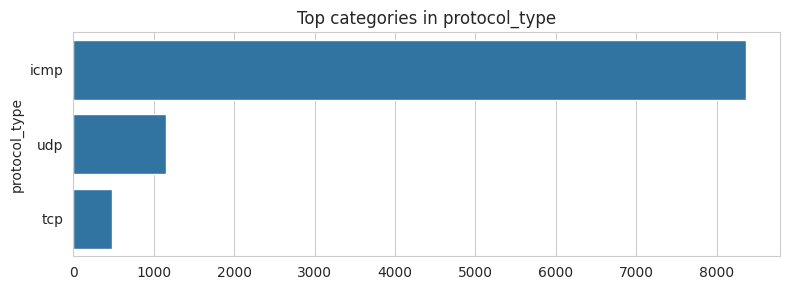

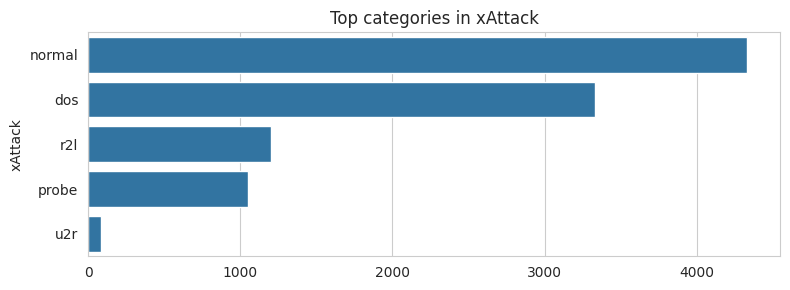

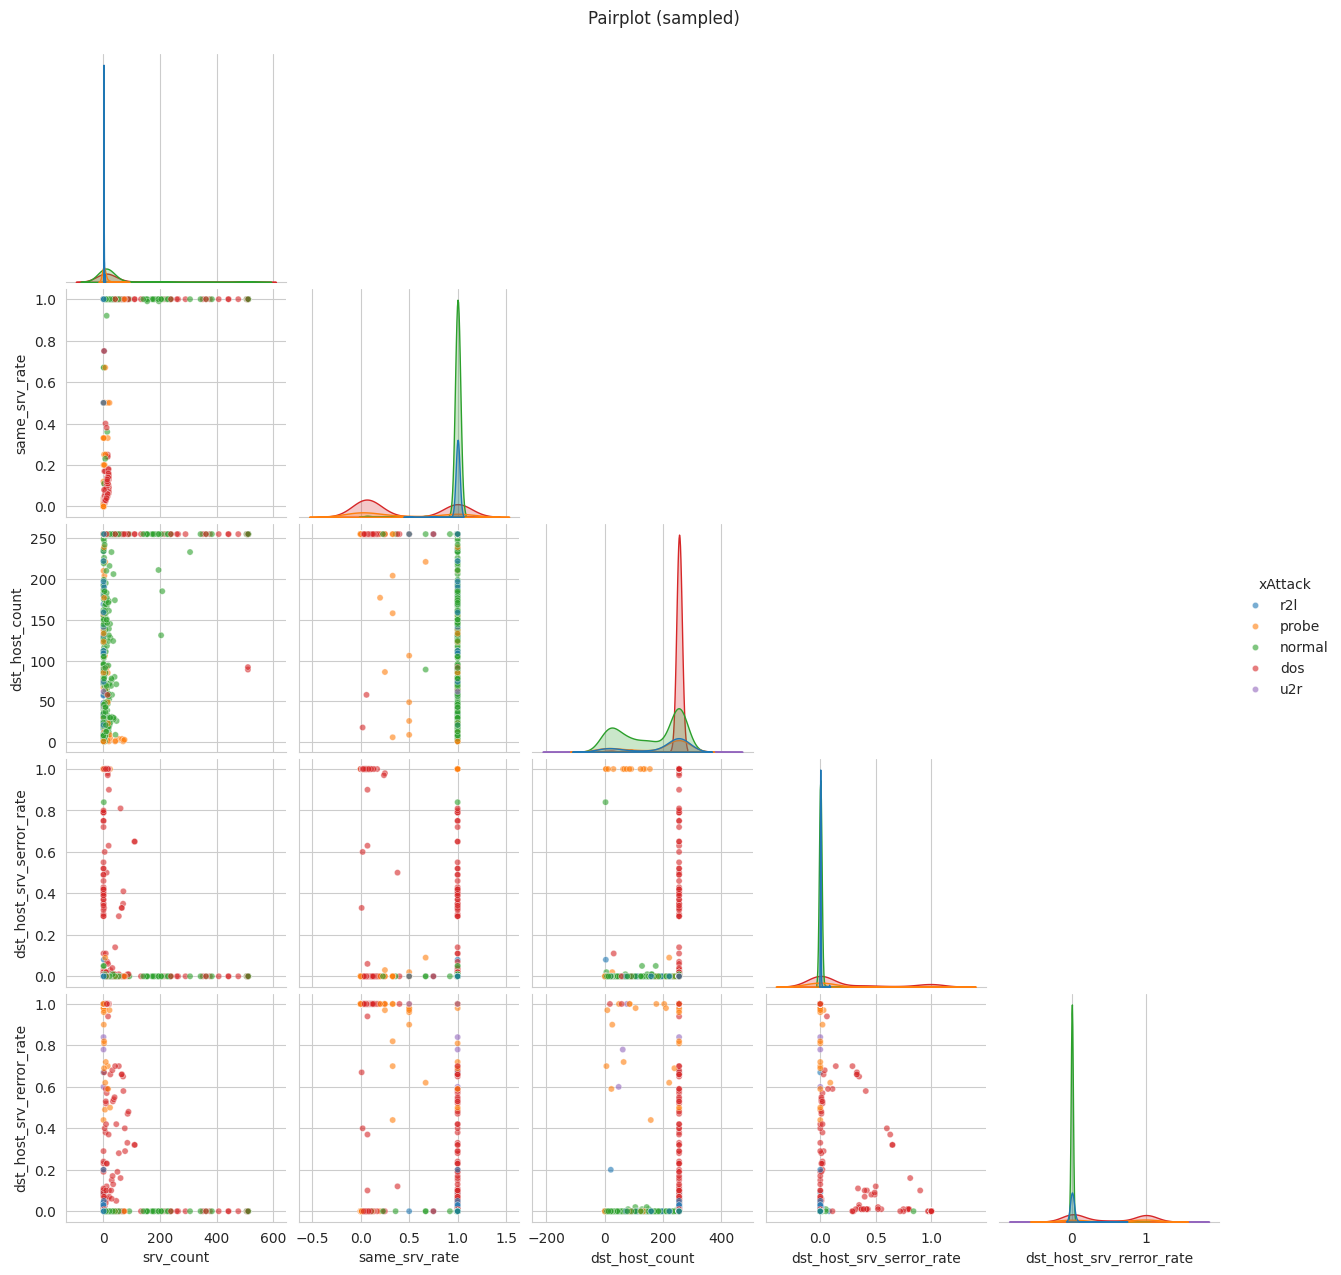


Rows with any numeric z-score > 3 (possible outliers): 3438 (34.380%)

EDA Summary


In [ ]:
# ---------------------------
# EXPLORATORY DATA ANALYSIS (EDA) `
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

print(">>> Quick dataset overview")
print("Shape:", data.shape)
print("\nColumns and dtypes:")
print(data.dtypes)

print("\n>>> First 5 rows:")
display(data.head())

# --- Missing values ---
print("\n>>> Missing values (by column):")
missing = data.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0] if missing.sum() > 0 else "No missing values detected")

# --- Target check ---
print("\n>>> Target ('xAttack') value counts:")
print(data['xAttack'].value_counts())
print("\nTarget proportions (normalized):")
print(data['xAttack'].value_counts(normalize=True).round(3))

# --- Basic numeric summaries ---
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nNumeric columns count:", len(numeric_cols))
print("Categorical columns count:", len(cat_cols))

print("\n>>> Numeric summary (describe):")
if len(numeric_cols) > 0:
    display(data[numeric_cols].describe().T)
else:
    print("No numeric columns to describe.")

# --- Quick correlation check (top correlations with target if target numeric-encoded) ---
# If target is string, we will create a temporary encoded version for correlation only
if data['xAttack'].dtype == object:
    temp_target = pd.factorize(data['xAttack'])[0]
else:
    temp_target = data['xAttack'].values

# Correlation of numeric features with target
if len(numeric_cols) > 0:
    corrs = data[numeric_cols].corrwith(pd.Series(temp_target, index=data.index), method='spearman').abs().sort_values(ascending=False)
    print("\nTop 10 numeric features correlated (abs Spearman) with target:")
    display(corrs.head(10))
else:
    corrs = pd.Series(dtype=float)
    print("\nNo numeric columns to compute correlations.")

# --- Visualizations ---
# 1) Target distribution (bar)
plt.figure(figsize=(8,4))
sns.countplot(y='xAttack', data=data, order=data['xAttack'].value_counts().index)
plt.title("Target Distribution (counts)")
plt.tight_layout()
plt.show()

# 2) Histograms for numeric features
sample_numeric = numeric_cols[:25]  # choose first 25 numeric columns to visualize quickly
if len(sample_numeric) > 0:
    data[sample_numeric].hist(bins=30, figsize=(14, 10), layout=(6,5))
    plt.suptitle("Histograms (first 25 numeric features)")
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns to plot histograms.")

# 3) Boxplots for top 6 correlated numeric features
top_corr_feats = corrs.index.tolist()[1:7] if not corrs.empty else []
top_corr_feats = [c for c in top_corr_feats if c in numeric_cols][:6]
if top_corr_feats:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data[top_corr_feats], orient="h")
    plt.title("Boxplots for top correlated numeric features")
    plt.show()
else:
    print("Not enough correlated numeric features for boxplot.")

# 4) Correlation heatmap
if len(numeric_cols) > 0:
    sample_for_corr = data[numeric_cols].sample(n=min(10000, len(data)), random_state=42)
    corr_matrix = sample_for_corr.corr()

    n_cols_show = min(25, corr_matrix.shape[0], corr_matrix.shape[1])
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix.iloc[:n_cols_show, :n_cols_show], cmap="RdBu_r", center=0, annot=False)
    plt.title(f"Correlation heatmap (first {n_cols_show} numeric features by position)")
    plt.show()
else:
    print("No numeric columns to compute correlation heatmap.")

# 5) Categorical features counts (top categories)
for col in cat_cols:
    topn = data[col].value_counts().nlargest(10)
    plt.figure(figsize=(8,3))
    sns.barplot(x=topn.values, y=topn.index)
    plt.title(f"Top categories in {col}")
    plt.tight_layout()
    plt.show()

# 6) Pairplot of a small set of important features
pairplot_feats = corrs.index[1:6].tolist() if not corrs.empty else []
pairplot_feats = [c for c in pairplot_feats if c in numeric_cols]
if len(pairplot_feats) >= 2:
    sample_small = data[pairplot_feats + ['xAttack']].sample(n=min(1000, len(data)), random_state=42)
    sns.pairplot(sample_small, hue='xAttack', corner=True, vars=pairplot_feats, plot_kws={'s':20, 'alpha':0.6})
    plt.suptitle("Pairplot (sampled)", y=1.02)
    plt.show()
else:
    print("Not enough numerical features for pairplot (or none selected by correlation).")

# --- Outlier check: z-score method for numeric features
if len(numeric_cols) > 0:
    z_scores = np.abs(stats.zscore(data[numeric_cols].fillna(0), nan_policy='omit'))
    outlier_rows = (z_scores > 3).any(axis=1).sum()
    print(f"\nRows with any numeric z-score > 3 (possible outliers): {outlier_rows} ({outlier_rows/len(data):.3%})")
else:
    print("\nNo numeric columns to check outliers.")


if len(numeric_cols) > 0:
    # Used describe() which already contains 25%, 50%, 75% rows
    eda_summary = data[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
    eda_summary['missing'] = data[numeric_cols].isnull().sum().values
    eda_summary.to_csv("eda_numeric_summary.csv")
    print("\nEDA Summary")
else:
    print("\n")


